In [555]:
import pandas as pd
import numpy as np
from scipy.special import expit, logit

In [851]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.linear_model import LogisticRegression

In [567]:
import lightgbm as lgb

In [493]:
import matplotlib.pyplot as plt
import seaborn as sns

In [494]:
import weight_of_evidence

In [495]:
import importlib
importlib.reload(weight_of_evidence)

<module 'weight_of_evidence' from '/Users/olivercairns/Desktop/code/WeightOfEvidenceDemo/weight_of_evidence.py'>

In [496]:
np.random.seed=1234

In [725]:
company_age = np.arange(1,100,0.01)

In [872]:
standard_scaled_age = (company_age - company_age.mean()) / company_age.std()

In [873]:
linear_risk = expit(standard_scaled_age)

In [874]:
non_linear_risk = expit(standard_scaled_age**5)

In [875]:
def simulate_outcome(risk_vector):
    random_draws = np.random.uniform(size=risk_vector.shape)
    return (risk_vector > random_draws).astype(int)

In [876]:
def non_mono_fn(company_age):
    if company_age <= 25:
        return 0.25
    elif company_age <= 75:
        return 0.75
    else:
        return 0.25

In [878]:
non_mono_vec = np.vectorize(non_mono_fn)

In [879]:
non_mono_risk = non_lin_vec(company_age)

In [880]:
SCENARIOS = [(linear_risk, 'linear'),
    (non_linear_risk, 'non-linear'),
                      (non_mono_risk, 'non-monotonic')]

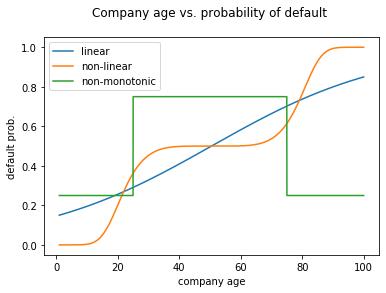

In [883]:
plt.plot(company_age,linear_risk)
plt.plot(company_age,non_linear_risk)
plt.plot(company_age,non_mono_risk)
plt.legend(['linear','non-linear','non-monotonic'])
plt.title('Company age vs. probability of default \n')
plt.xlabel('company age')
plt.ylabel('default prob.')

plt.show()

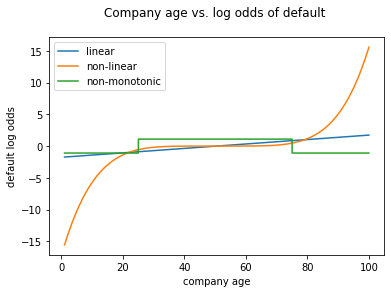

In [884]:
plt.plot(company_age,logit(linear_risk))
plt.plot(company_age,logit(non_linear_risk))
plt.plot(company_age,logit(non_mono_risk))
plt.legend(['linear','non-linear','non-monotonic'])
plt.title('Company age vs. log odds of default \n')
plt.xlabel('company age')
plt.ylabel('default log odds')

plt.show()

In [885]:
MODELS = (
  ('lightgbm',  lgb.LGBMClassifier()),
('log reg',LogisticRegression(solver='lbfgs')))

In [886]:
results = {'scenario':[],'roc_auc':[],'brier':[],'model':[]}
for risk_vector, scenario_name in SCENARIOS:
    for model_name, classifier in MODELS: 
        for _ in range(10):
            y_train = simulate_outcome(risk_vector)
            y_test  = simulate_outcome(risk_vector)
            X = np.array([company_age]).T
            classifier.fit(X,y_train)
            y_pred = classifier.predict_proba(X)[:,1]
            roc_auc = roc_auc_score(y_test,y_pred)
            brier = brier_score_loss(y_test,y_pred)

            results['scenario'].append(scenario_name)
            results['roc_auc'].append(roc_auc)
            results['brier'].append(brier)
            
            results['model'].append(model_name)
        

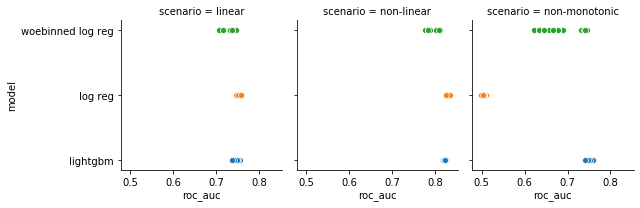

In [910]:
g = sns.FacetGrid(data=pd.DataFrame(results),col='scenario',hue='model')
g.map(sns.scatterplot,'roc_auc','model')

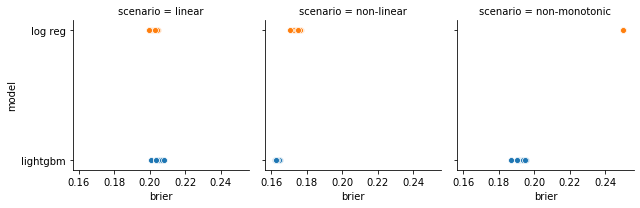

In [887]:
g = sns.FacetGrid(data=pd.DataFrame(results),col='scenario',hue='model')
g.map(sns.scatterplot,'brier','model')

In [888]:
tree_binner = weight_of_evidence.TreeBinner(max_depth=2)

In [889]:
y_train = simulate_outcome(non_mono_risk)
y_test  = simulate_outcome(non_mono_risk)


In [890]:
X = pd.DataFrame(data=X, columns=['company_age'])

In [891]:
y_train = pd.Series(y_train)

In [892]:
X_binned= tree_binner.fit_transform(X,y_train)

In [893]:
X_binned.company_age.unique()

array(['(-inf, 25.03]', '(25.03, 83.26]', '(83.26, inf]'], dtype=object)

In [894]:
woe_scaler = weight_of_evidence.WoeScaler()

In [895]:
X_woe = woe_scaler.fit_transform(X_binned,y_train)

In [896]:
woe_scaler.woe_values_

{'company_age': {'(-inf, 25.03]': -1.0460550379294336,
  '(25.03, 83.26]': 0.7516890599781353,
  '(83.26, inf]': -1.1642494523080889}}

In [897]:
ss = StandardScaler()

In [898]:
X_ss = ss.fit_transform(X_woe)

Text(0.5, 1.0, 'Distribution of values - Woe binned & standard scaled \n')

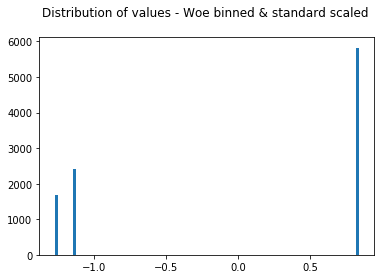

In [899]:
ax = plt.hist(X_ss,bins=100)
plt.title('Distribution of values - Woe binned & standard scaled \n')

In [904]:
woebin_logit = Pipeline(
        steps=[
            ("tree_bin", weight_of_evidence.TreeBinner(max_depth=3)),
            ("woe_scale", weight_of_evidence.WoeScaler()),
            ("standard_scale", StandardScaler()),
            ('log_reg_classifier',LogisticRegression(solver='lbfgs') ),
        ]
    )

In [905]:
for risk_vector, scenario_name in SCENARIOS:
    for _ in range(10):
        y_train = pd.Series(simulate_outcome(risk_vector))
        y_test  = simulate_outcome(risk_vector)
        X = np.array([company_age]).T
        X = pd.DataFrame(data=X, columns=['company_age'])
        
        woebin_logit.fit(X,y_train)
        y_pred = woebin_logit.predict_proba(X)[:,1]
        auc = roc_auc_score(y_test,y_pred)
        brier = brier_score_loss(y_test,y_pred)

        results['scenario'].append(scenario_name)
        results['roc_auc'].append(auc)
        results['brier'].append(brier)

        results['model'].append('woebinned log reg')

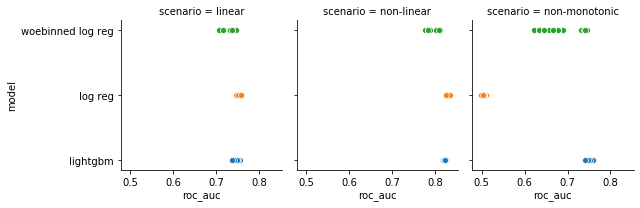

In [909]:
g = sns.FacetGrid(data=pd.DataFrame(results),col='scenario',hue='model')
g.map(sns.scatterplot,'roc_auc','model')

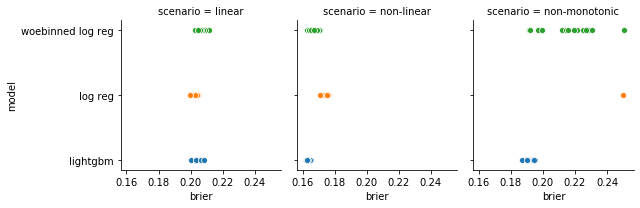

In [906]:
g = sns.FacetGrid(data=pd.DataFrame(results),col='scenario',hue='model')
g.map(sns.scatterplot,'brier','model')

In [908]:
pd.DataFrame(results).groupby(['scenario','model'])[['brier']].mean()

brier
scenario      model                      
linear        lightgbm           0.204886
              log reg            0.201136
              woebinned log reg  0.206393
non-linear    lightgbm           0.163336
              log reg            0.174349
              woebinned log reg  0.166736
non-monotonic lightgbm           0.192090
              log reg            0.250008
              woebinned log reg  0.219423